# A Simple Example of Solving PDE with DL

In [19]:
import time

import torch
import numpy as np
from tqdm import trange
from torch import nn, autograd, optim

%matplotlib notebook 
import matplotlib.pyplot as plt
from matplotlib import animation

In [20]:
class Anime:
    """
    Args:
        data        two-tuple: (x, y)
                    x is a discretization along X axis
                    y[t] is the target values at x points
                    at time t
    """
    def __init__(self, fig, data, label=None):
        self.line, = plt.plot([], [], lw=2, label=label)
        plt.xlim(data[0].min(), data[0].max())
        self.anime = animation.FuncAnimation(
            fig, self.update, init_func=self.init, 
            frames=400, interval=20, repeat=False, blit=True)
    # << `repeat=True` leads to the divergence of graphs if there are more than 2
        
        self.data = data

    def init(self):
        self.line.set_data([], [])

    def update(self, t):
        x, y = self.data
        self.line.set_data(x, y[t])

In [21]:
# Exact solution of the problem {du/dt + a du/dx = 0, u(0, x) = gauss(x)}
def dome(x, t=0, a=.5, alpha=200):
    if isinstance(t, torch.Tensor):
        t = t[:, None]
    
    return torch.exp(-alpha * ((x-.25) - a*t)**2)

In [22]:
def running_mean(signal, ww=80):
    """
    Args:
    -----
        ww        window width
    """
    return np.convolve(signal, np.ones(ww)/ww, mode='valid')

In [23]:
class HGAESolver(nn.Module):
    """
    Homogeneous Advection Equation Solver
    -------------------------------------
    du/dt + a du/dx = 0
    u(0, x) = gauss(x)
    -------------------------------------
    Type of PDE does not effect the network
    architecture, only the training pipeline
    -------------------------------------
    Args:
        a                 wave velocity
        l                 length of calculation area along x axis
                          (starting from 0)
        T                 length of calculation area along t axis
                          (starting from 0)
                          
                          Thus, (0, l) x (0, T) is the training domain
                          
        hyppar            loss hyperparameters defining balance
                          among the approximation of PDE and 
                          boundary conditions
    """
    def __init__(
        self, arch='3l', a=.5, l=1., T=2.,
        hyppar=(1., 1.), left_bc=False, device='cpu'):
        
        super().__init__()
        self.a = a
        self.l = l
        self.T = T
        self.u_0x = torch.tensor([0.])
        self.hyppar = hyppar
        self.left_bc = left_bc
        self.device = device
        
        arch_3l =  nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1))
        
        arch_6l = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, 1))
        
        if arch == '3l': self.main = arch_3l
        elif arch == '6l': self.main = arch_6l
        else: raise TypeError("Arg 'arch' must be '3l' or '6l'")
            
        self.main = self.main.to(device)
        self.u_0x = self.u_0x.to(device)
        
    def forward(self, x):
        return self.main(x)
    
    def sampleBatch(self, N=5120, M=4096, K=2048):
        """
        N - number of points to sample in the domain (x, t)
        M - __..__..__..__..__ to sample on the x axis
        """
        x = torch.zeros(M, 2, device=self.device)
        x[:, 1] = self.l * torch.rand(M, device=self.device)
        
        tx = torch.rand(N, 2, device=self.device)
        tx[:, 0].mul_(self.T)
        tx[:, 1].mul_(self.l)
        
        if self.left_bc:
            t0 = torch.zeros(K, 2, device=self.device)
            t0[:, 0] = torch.rand(K, device=self.device)
            return tx, x, t0
        return tx, x

    def computeLoss(self, x_domain, x_border, y_domain, y_border, y_point=None):
        jacobian = autograd.grad(
            outputs=y_domain, inputs=x_domain,
            grad_outputs=torch.ones_like(y_domain),
            create_graph=True)[0]
        du_t, du_x = torch.unbind(jacobian, 1)
        
        L = torch.norm(du_t + self.a * du_x) 
        L = L + self.hyppar[0] * torch.norm(y_border.view(-1) - dome(x_border[:, 1], a=self.a)) 
        if self.left_bc:
            L = L + self.hyppar[1] * torch.norm(y_point.view(-1) - self.u_0x)
            
        return L

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_batches = int(1e4)
# in fact, 1000 iterations is more than enough
# to obtain a decent approximation in the training domain
solver = HGAESolver(left_bc=True, device=device)
optimizer = optim.Adam(solver.parameters())

In [44]:
loss_history = []
try:
    for _ in trange(num_batches, desc='Training'):
        optimizer.zero_grad()

        batches = solver.sampleBatch(40, 40, 40)
        batches[0].requires_grad_(True)
        outputs = []
        for b in batches:
            outputs.append(solver(b))

        loss = solver.computeLoss(*batches[:2], *outputs)
        loss_history.append(loss.item())
        loss.backward()

        optimizer.step()
        
except KeyboardInterrupt:
    pass

Training: 100%|██████████| 10000/10000 [01:32<00:00, 92.65it/s]


<IPython.core.display.Javascript object>


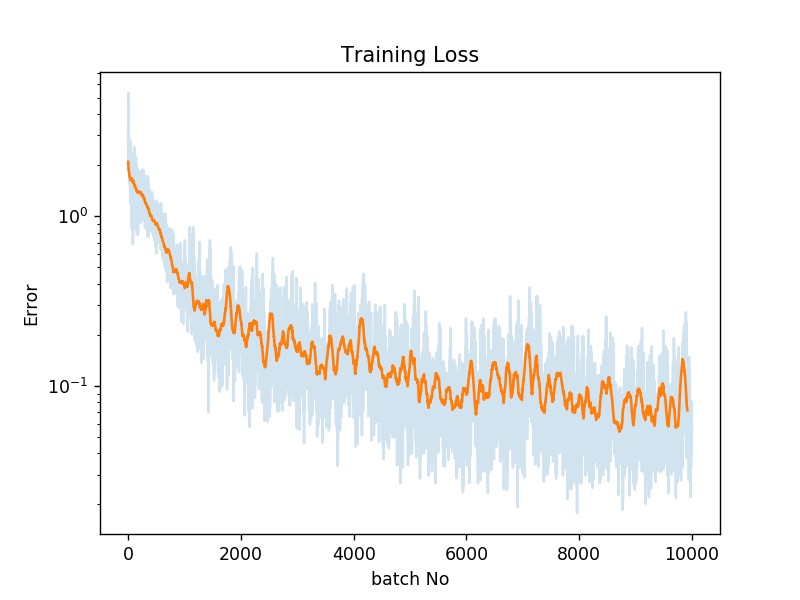

In [45]:
plt.figure()
plt.plot(loss_history, alpha=.2)
plt.plot(running_mean(loss_history))
plt.yscale('log')
plt.title('Training Loss')
plt.ylabel('Error')
plt.xlabel('batch No');

In [51]:
max_error = lambda u_exact, u_approx: torch.norm(u_exact - u_approx.view(-1), p=float('inf'))
avg_error = lambda u_exact, u_approx: torch.mean((u_exact - u_approx.view(-1))**2)**.5 

## Initial Condition approximation

max error 0.01415957324206829
avg error 0.009423169307410717


<IPython.core.display.Javascript object>


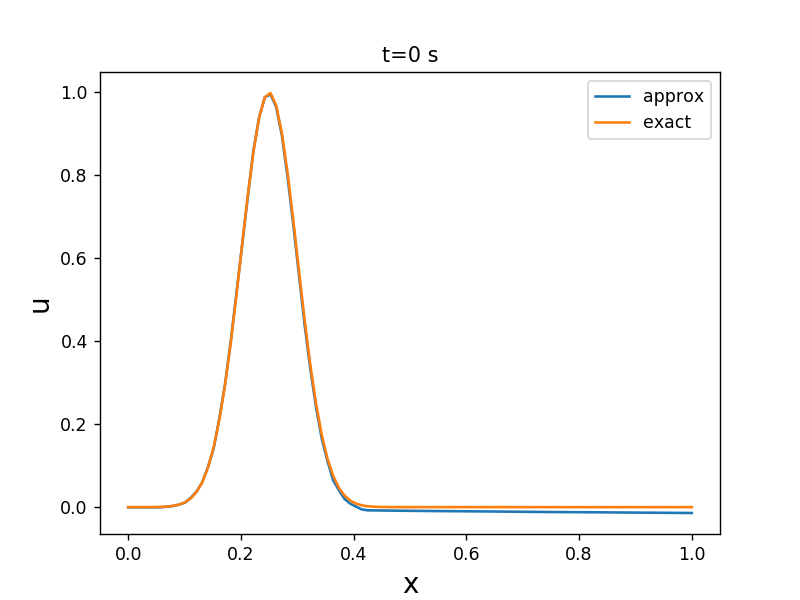

In [52]:
x = torch.linspace(0, 1)
tx = torch.stack((torch.zeros_like(x), x), 1)

y_true = dome(x)
y = solver(tx.to(device)).detach().cpu()
print('max error', max_error(y_true, y).item())
print('avg error', avg_error(y_true, y).item())
x = x.numpy()

plt.figure()
plt.plot(x, y.numpy(), label='approx')
plt.plot(x, y_true.numpy(), label='exact')
plt.xlabel('x', size=16)
plt.ylabel('u', size=16)
plt.title('t=0 s')
plt.legend();

## Approximation at time `t`

max error 0.01108459010720253
avg error 0.004728635773062706


<IPython.core.display.Javascript object>


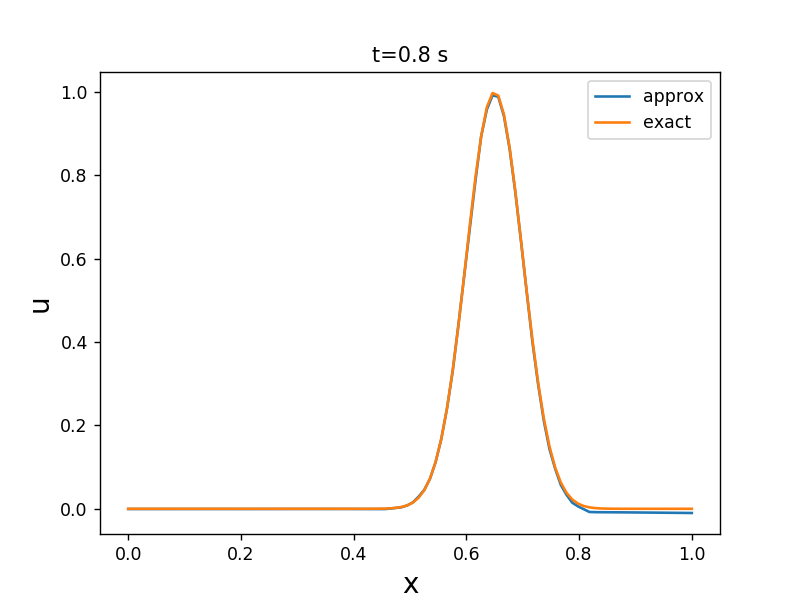

In [53]:
t = .8 
x = torch.linspace(0, 1)
tx = x.new(len(x), 2)
tx[:, 0].fill_(t)
tx[:, 1] = x

y_true = dome(x, t)
y = solver(tx.to(device)).detach().cpu()
print('max error', max_error(y_true, y).item())
print('avg error', avg_error(y_true, y).item())
x = x.numpy()

plt.figure()
plt.plot(x, y.numpy(), label='approx')
plt.plot(x, y_true.numpy(), label='exact')
plt.xlabel('x', size=16)
plt.ylabel('u', size=16)
plt.title(f't={t} s')
plt.legend();

## Run cell to start animating
if there is only one graph, re-run the cell

---
As expected, the approximation is fairly good on the training data, and when the model encounters test data the solutions begin to diverge

<IPython.core.display.Javascript object>


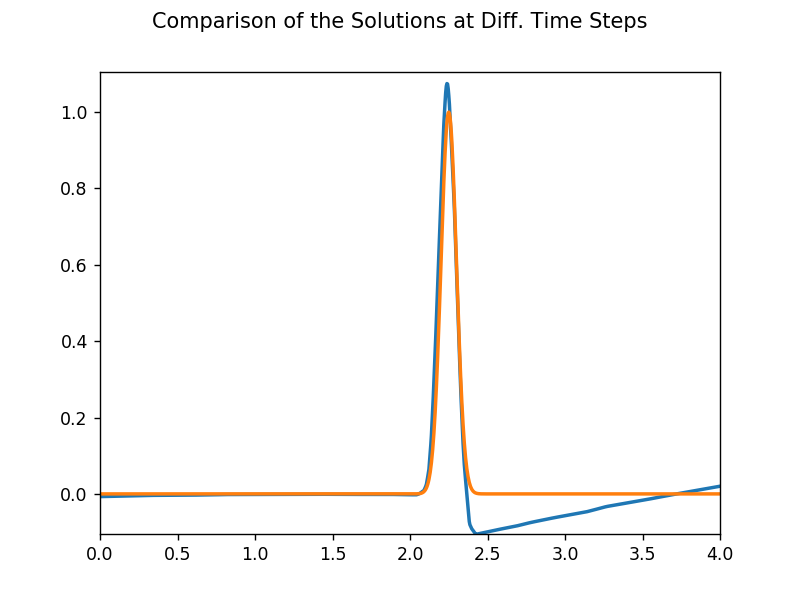

In [54]:
z = torch.linspace(0, 4, 1000)
t = torch.linspace(0, 4)
y = dome(z, t)
true_data = (z.numpy(), y.numpy())

t = t.view(-1, 1)
t = t.expand(-1, len(z))
x = z.view(1, -1)
x = x.expand(len(t), -1)
tx = torch.stack((t, x), -1)
y = solver(tx.to(device)).view(len(tx), -1).detach().cpu()
appr_data = (z.numpy(), y.numpy())

fig = plt.figure()
fig.suptitle('Comparison of the Solutions at Diff. Time Steps')
Anime(fig, appr_data)
Anime(fig, true_data);

# test data begins when dome at x = a * T = .5 * 2 = 1

---
# Solving the problem with finite-difference method

$$
\left\{\begin{aligned}
    &u_i^{n+1} = u_i^n + a\Delta t (u_{i-1}^n- u_i^n)\\
    &u_i^0 = \exp(-\alpha(i\Delta h - 0.25)^2)\\
    &u_0^n = 0
\end{aligned}\right.
$$

In [50]:
l = 1
T = 1
u_t0 = torch.tensor([0.])
dx = 1e-3
rdx = 1 / dx
dt = 2e-3
a = .5

x = torch.linspace(0, l, int(l/dx))
u_0x = dome(x, a=a)
u_exact = dome(x, t=T, a=a)

def one_time_step(u):
    return u + torch.cat([u_t0, -a*dt*rdx * (u[1:] - u[:-1])])

In [130]:
u1 = u_0x
for i in range(int(.5 * T / dt)):
    u2 = one_time_step(u1)
    u1 = one_time_step(u2)

<IPython.core.display.Javascript object>


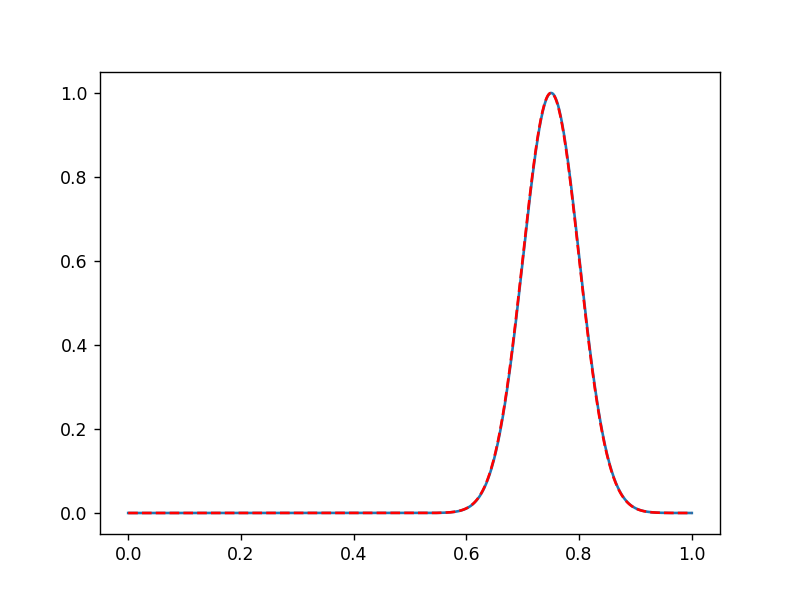

max error 0.0060707926750183105
avg error 0.002106061205267906


In [132]:
plt.figure()
print('max error', max_error(u_exact, u1).item())
print('avg error', avg_error(u_exact, u1).item())
plt.plot(x.numpy(), u1.numpy())
plt.plot(x.numpy(), u_exact.numpy(), '--r');